# compose

In [1]:
import pandas as pd
from util import plot_scores, plt, sns, wrap_labels

# warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore",
                        category=UserWarning)  # hide: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def sort_df(df, attributes_to_sort_by):
    """
    WARNING: A dict has no order, so only one attribute to sort by is recommended

    Sort the dataframe based on the given attributes and the order in their list
    :param df: Dataframe to sort
    :param attributes_to_sort_by: List of attributes to sort by (dict, keys are the attributes, values are the order)
    :return: Sorted dataframe
    """
    df_len = len(df)

    df = df.copy()

    # sort them in reverse order, so they will finally be sorted on the first attribute
    for key, value in reversed(attributes_to_sort_by.items()):

        new_df = pd.DataFrame()
        for v in value:
            new_df = pd.concat([new_df, df[df[key] == v]])

        # add the rest of the dataframe
        new_df = pd.concat([new_df, df[~df[key].isin(value)]])

        df = new_df

    assert len(df) == df_len, "Sorting went wrong, length of dataframe changed"
    return df


def compose_all(inputs, output=None, models_to_keep=None, attributes_to_keep=None):
    """
    Compose all the data from the different models into one file
    :param inputs: Array of score csv files to combine
    :param output: Output file
    :param models_to_keep: List of strings containing the names of the models to keep (of None, keep all)
    :param attributes_to_keep: Dict of list where the key is a column name and the value is a list of values to keep
    :return:
    """
    if models_to_keep is not None:
        attributes_to_keep = {} if attributes_to_keep is None else attributes_to_keep
        attributes_to_keep['model'] = models_to_keep

    df = pd.DataFrame()

    for i in inputs:
        df = pd.concat([df, pd.read_csv(i)])

    if attributes_to_keep is not None:
        for key, value in attributes_to_keep.items():
            df = df[df[key].isin(value)]

        # sort in the order of the (categorical) lists in attributes_to_keep
        df = df.sort_values(by=list(attributes_to_keep.keys()))

    if 'model' in attributes_to_keep:
        df = sort_df(df, {'model': attributes_to_keep['model']})

    df.to_csv(output, index=False) if output is not None else None

    return df


base_all = ['outputs/model-evaluations-20230519-223940-GILGFVFTL-50-fixed-test-size/scores-20230519-224017.csv',
            'outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
            'outputs/model-evaluations-20230518-133505-GILGFVFTL-200-fixed-test-size/scores-20230518-133605.csv',
            'outputs/model-evaluations-20230518-133659-GILGFVFTL-500-fixed-test-size/scores-20230518-133906.csv',
            'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
            'outputs/model-evaluations-20230518-134717-GILGFVFTL-2000-fixed-test-size/scores-20230518-140119.csv',
            'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
            'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv']

In [3]:
%%script echo skipping
title = "Impact of dataset size (variable test size)"
df = compose_all(['outputs/model-evaluations-20230518-125400-GILGFVFTL-200/scores-20230518-125447.csv',
                  'outputs/model-evaluations-20230518-125507-GILGFVFTL-500/scores-20230518-125701.csv',
                  'outputs/model-evaluations-20230518-125813-GILGFVFTL-1000/scores-20230518-130302.csv',
                  'outputs/model-evaluations-20230518-130554-GILGFVFTL-2000/scores-20230518-131925.csv'],
                 'composed_data/GILGFVFTL-different-sizes.csv',
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (KNN imputed, k=5)",
                     "HistGradientBoosting",
                     "Random Forest (Seperate chains)"
                 ])
plot_scores(df, title, hue="df_size", wrap=True, hue_group_diff=False)

Couldn't find program: 'echo'


In [4]:
# %%script echo skipping

title = "Impact of dataset size (fixed test size)"
# Disclaimer: same test set was (accidentaly) used for all of the 5 folds, training set was different per fold
df = compose_all(base_all,
                 'composed_data/GILGFVFTL-different-sizes-fixed-test-size.csv',
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (KNN imputed, k=5)",
                     "HistGradientBoosting",
                     "Random Forest (Seperate chains)"
                 ])
# plot_scores(df, title, hue="df_size", wrap=True, hue_group_diff=False)

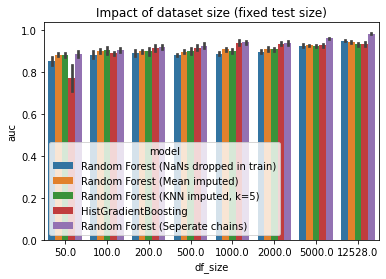

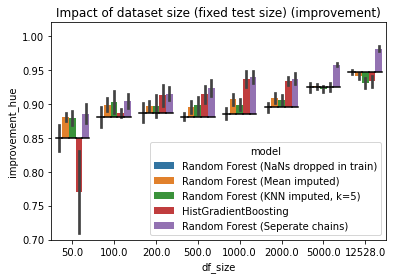

In [5]:
plot_scores(df, title, wrap=True, x="df_size", hue="model")

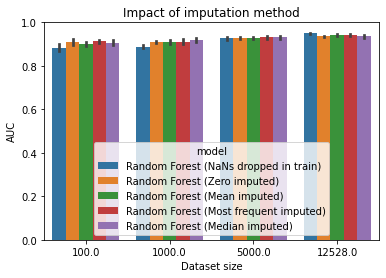

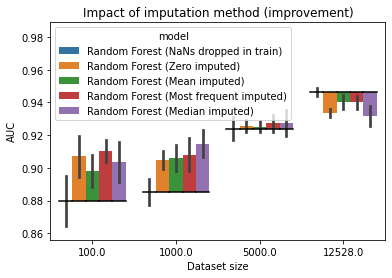

In [6]:
title = "Impact of imputation method"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Zero imputed)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Most frequent imputed)",
                     "Random Forest (Median imputed)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-simple-imputation-methods.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

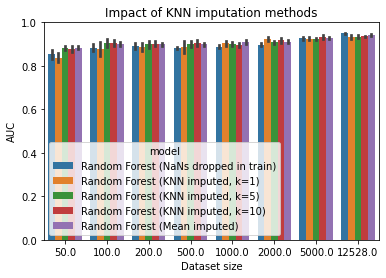

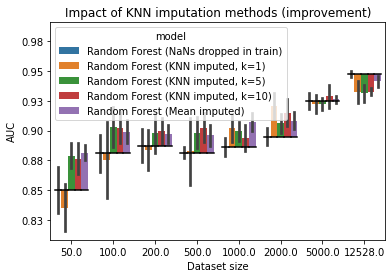

In [7]:
title = "Impact of KNN imputation methods"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (KNN imputed, k=1)",
                     'Random Forest (KNN imputed, k=5)',
                     'Random Forest (KNN imputed, k=10)',
                     "Random Forest (Mean imputed)",
                 ])

output = 'graphs/GILGFVFTL-knn-imputation-methods.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

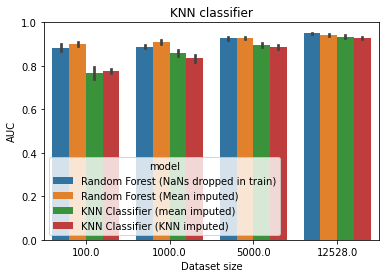

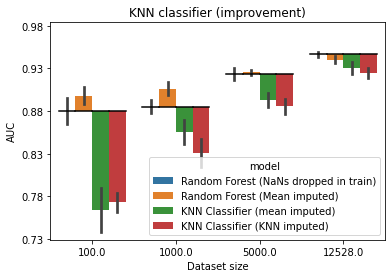

In [8]:
title = "KNN classifier"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "KNN Classifier (mean imputed)",
                     "KNN Classifier (KNN imputed)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-knn-classifier.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

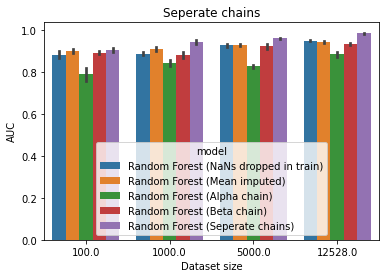

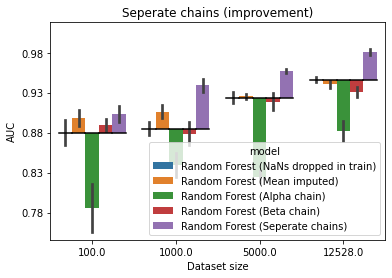

In [9]:
title = "Seperate chains"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Alpha chain)",
                     "Random Forest (Beta chain)",
                     "Random Forest (Seperate chains)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-seperate-chains.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

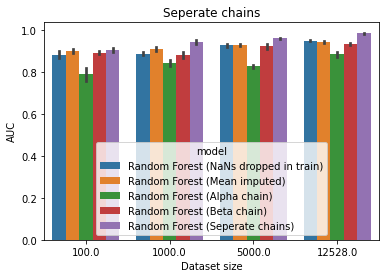

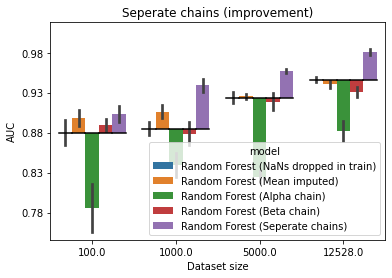

In [10]:
title = "Seperate chains"

df = compose_all(base_all,
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Alpha chain)",
                     "Random Forest (Beta chain)",
                     "Random Forest (Seperate chains)"
                 ],
                 attributes_to_keep={
                     "df_size": [100, 1000, 5000, 12528]
                 })

output = 'graphs/GILGFVFTL-seperate-chains.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

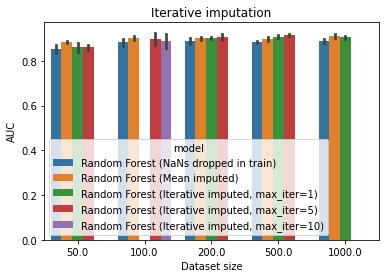

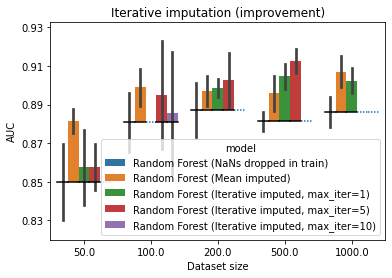

In [11]:
title = "Iterative imputation"

iterative_results = [
    'outputs/model-evaluations-20230521-200717-GILGFVFTL-50--iterative-imputers/1-Random Forest (Iterative imputed, max_iter=1).csv',
    'outputs/model-evaluations-20230521-200717-GILGFVFTL-50--iterative-imputers/2-Random Forest (Iterative imputed, max_iter=5).csv',

    'outputs/model-evaluations-20230521-202243-GILGFVFTL-100--iterative-imputers/2-Random Forest (Iterative imputed, max_iter=5).csv',
    'outputs/model-evaluations-20230521-202243-GILGFVFTL-100--iterative-imputers/3-Random Forest (Iterative imputed, max_iter=10).csv',

    'outputs/model-evaluations-20230522-071321-GILGFVFTL-200--iterative-imputers/scores-20230522-072955.csv',

    'outputs/model-evaluations-20230522-073856-GILGFVFTL-500--iterative-imputers/scores-20230522-084148.csv',

    'outputs/model-evaluations-20230522-155837-GILGFVFTL-1000--iterative-imputers/1-Random Forest (Iterative imputed, max_iter=1).csv']

df = compose_all(base_all + iterative_results,
                 None,
                 models_to_keep=["Random Forest (NaNs dropped in train)",
                                 "Random Forest (Mean imputed)",
                                 "Random Forest (Iterative imputed, max_iter=1)",
                                 "Random Forest (Iterative imputed, max_iter=5)",
                                 "Random Forest (Iterative imputed, max_iter=10)"],
                 attributes_to_keep={'df_size': [50, 100, 200, 500, 1000]})

output = 'graphs/GILGFVFTL-iterative-imputers.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

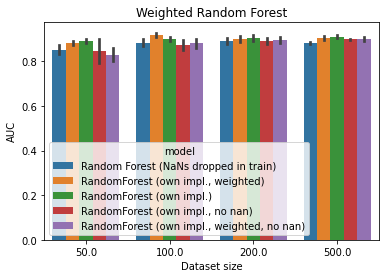

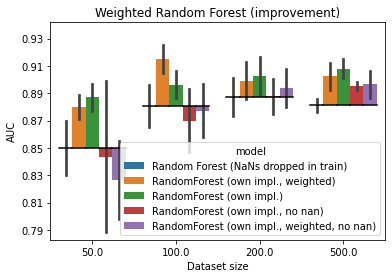

In [12]:
title = "Weighted Random Forest"

df = compose_all(
    base_all + ['outputs/model-evaluations-20230522-203946-GILGFVFTL-50-weighted-rf/scores-20230522-204407.csv',
                'outputs/model-evaluations-20230522-204411-GILGFVFTL-100-weighted-rf/scores-20230522-205100.csv',
                'outputs/model-evaluations-20230522-205105-GILGFVFTL-200-weighted-rf/scores-20230522-211114.csv',
                'outputs/model-evaluations-20230522-213519-GILGFVFTL-500-weighted-rf/scores-20230522-232154.csv'],
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "RandomForest (own impl., weighted)",
                    "RandomForest (own impl.)",
                    "RandomForest (own impl., no nan)",
                    "RandomForest (own impl., weighted, no nan)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500]})

output = 'graphs/GILGFVFTL-weighted-rf.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

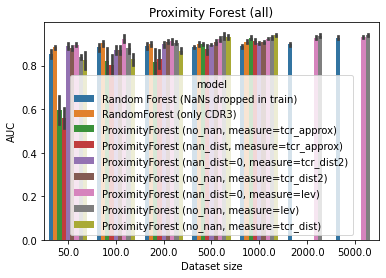

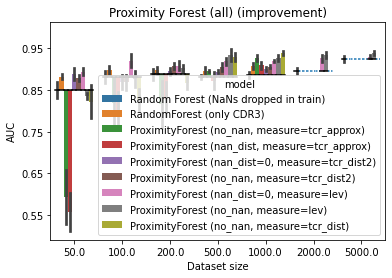

In [13]:
title = "Proximity Forest (all)"

proximity_models = [
    'outputs/model-evaluations-20230523-160628-GILGFVFTL-50-distance-models-cdr/scores-20230523-160732.csv',
    'outputs/model-evaluations-20230523-160737-GILGFVFTL-100-distance-models-cdr/scores-20230523-160931.csv',
    'outputs/model-evaluations-20230523-160936-GILGFVFTL-200-distance-models-cdr/scores-20230523-161238.csv',
    'outputs/model-evaluations-20230523-163303-GILGFVFTL-500-distance-models-cdr/scores-20230523-164535.csv',
    'outputs/model-evaluations-20230523-164543-GILGFVFTL-1000-distance-models-cdr/scores-20230523-170918.csv',

    'outputs/model-evaluations-20230523-191340-GILGFVFTL-50-distance-models-cdr/scores-20230523-191424.csv',
    'outputs/model-evaluations-20230523-191428-GILGFVFTL-100-distance-models-cdr/scores-20230523-191550.csv',
    'outputs/model-evaluations-20230523-191555-GILGFVFTL-200-distance-models-cdr/scores-20230523-191834.csv',
    'outputs/model-evaluations-20230523-191840-GILGFVFTL-500-distance-models-cdr/scores-20230523-192808.csv',
    'outputs/model-evaluations-20230523-192816-GILGFVFTL-1000-distance-models-cdr/scores-20230523-195447.csv',

    'outputs/model-evaluations-20230523-225602-GILGFVFTL-50-distance-models-cdr-tcr-dist2/scores-20230523-225704.csv',
    'outputs/model-evaluations-20230523-225611-GILGFVFTL-50-distance-models-cdr-lev/scores-20230523-225954.csv',
    'outputs/model-evaluations-20230523-225710-GILGFVFTL-100-distance-models-cdr-tcr-dist2/scores-20230523-225851.csv',
    'outputs/model-evaluations-20230523-225856-GILGFVFTL-200-distance-models-cdr-tcr-dist2/scores-20230523-230141.csv',
    'outputs/model-evaluations-20230523-225958-GILGFVFTL-100-distance-models-cdr-lev/scores-20230523-230659.csv',
    'outputs/model-evaluations-20230523-230147-GILGFVFTL-500-distance-models-cdr-tcr-dist2/scores-20230523-232509.csv',
    'outputs/model-evaluations-20230523-230704-GILGFVFTL-200-distance-models-cdr-lev/scores-20230523-232028.csv',
    'outputs/model-evaluations-20230523-232034-GILGFVFTL-500-distance-models-cdr-lev/scores-20230523-234855.csv',
    'outputs/model-evaluations-20230523-232518-GILGFVFTL-1000-distance-models-cdr-tcr-dist2/scores-20230524-020042.csv',
    'outputs/model-evaluations-20230523-234903-GILGFVFTL-1000-distance-models-cdr-lev/scores-20230524-003951.csv',
    'outputs/model-evaluations-20230524-004003-GILGFVFTL-2000-distance-models-cdr-lev/scores-20230524-022222.csv',
    'outputs/model-evaluations-20230524-022248-GILGFVFTL-5000-distance-models-cdr-lev/scores-20230524-063154.csv',

]

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "RandomForest (only CDR3)",
                    "ProximityForest (no_nan, measure=tcr_approx)",
                    "ProximityForest (nan_dist, measure=tcr_approx)",
                    "ProximityForest (nan_dist=0, measure=tcr_dist2)",
                    "ProximityForest (no_nan, measure=tcr_dist2)",
                    "ProximityForest (nan_dist=0, measure=lev)",
                    "ProximityForest (no_nan, measure=lev)",
                    "ProximityForest (no_nan, measure=tcr_dist)",
                    "ProximityForest (nan_dist=150, measure=tcr_dist)" # is er nog niet denk ik
                    ],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-all.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

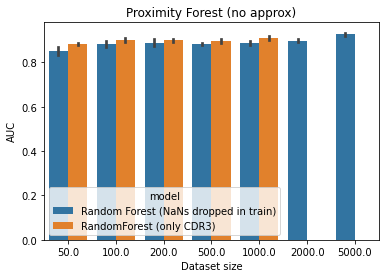

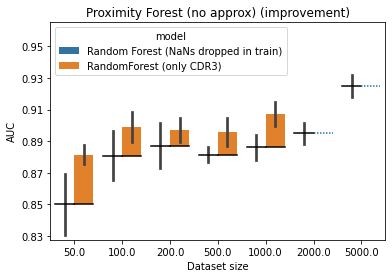

In [14]:
title = "Proximity Forest (no approx)"
df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "RandomForest (only CDR3)",
                    "RandomForest (mean imputed)"
                    # "ProximityForest (nan_dist=0, measure=tcr_dist2)",
                    # "ProximityForest (no_nan, measure=tcr_dist2)",
                    # "ProximityForest (nan_dist=0, measure=lev)",
                    # "ProximityForest (no_nan, measure=lev)",
                    # "ProximityForest (no_nan, measure=tcr_dist)",
                    # "ProximityForest (nan_dist=150, measure=tcr_dist)" # is er nog niet denk ik
                    ],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-all-noaproox.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

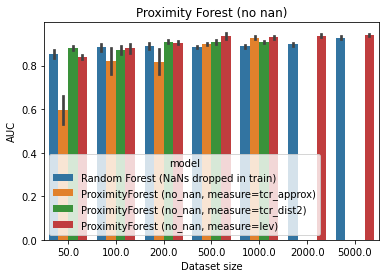

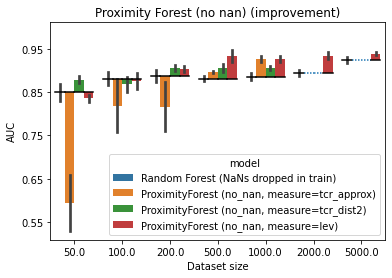

In [15]:
title = "Proximity Forest (no nan)"

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "ProximityForest (no_nan, measure=tcr_approx)",
                    "ProximityForest (no_nan, measure=tcr_dist2)",
                    "ProximityForest (no_nan, measure=lev)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

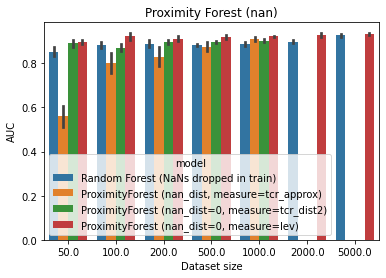

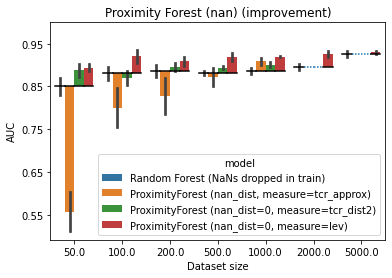

In [16]:
title = "Proximity Forest (nan)"

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "ProximityForest (nan_dist, measure=tcr_approx)",
                    "ProximityForest (nan_dist=0, measure=tcr_dist2)",
                    "ProximityForest (nan_dist=0, measure=lev)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

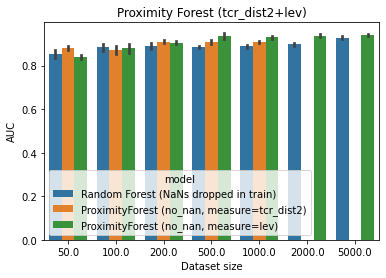

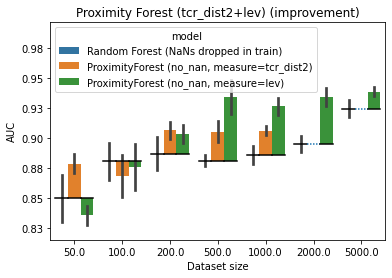

In [17]:
title = "Proximity Forest (tcr_dist2+lev)"

df = compose_all(
    base_all + proximity_models,
    None,
    models_to_keep=["Random Forest (NaNs dropped in train)",
                    "ProximityForest (no_nan, measure=tcr_dist2)",
                    "ProximityForest (no_nan, measure=lev)"],
    attributes_to_keep={'df_size': [50, 100, 200, 500, 1000, 2000, 5000]})

output = 'graphs/GILGFVFTL-proximity-forest-nonan.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)